# Questions for today

- Time series data acquisition struggles
- Class imbalance: should we find different data?
- How could we rethink the target variable?
- Is 5% too many outliers to remove?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.spatial import distance

# Reading in Data

In [2]:
info = pd.read_csv('patient_information.csv')
info.head()

,PID,Age,Ht,Wt,Gender,OR_start,OR_end,Surgery_start,Surgery_end,Procedure
0,56d1bc3e2a07cc1a,19,160,51,F,1/1/16 7:30,1/1/16 15:25,1/1/16 8:29,1/1/16 15:14,"Funtional rhinoplasty, repair of vestibular st..."
1,411a637540c1d665,51,162,71,F,12/26/16 7:11,12/26/16 8:32,12/26/16 7:50,12/26/16 8:21,"Excision Ganglion Cyst left dorsal hand,splint..."
2,51206705422a4c5c,41,165,58,F,6/19/16 8:15,6/19/16 13:37,6/19/16 8:57,6/19/16 13:37,"Abdominoplasty, Bilateral Flank Liposuction"
3,40750c9577f139bd,55,162,66,F,12/11/15 13:13,12/11/15 20:09,12/11/15 14:07,12/11/15 19:51,"1.Bilateral endoscopic sinus surgery, inferior..."
4,ed4ac97e460b5a79,41,158,76,F,4/18/16 7:11,4/18/16 9:31,4/18/16 8:07,4/18/16 9:31,Left breast: Tissue expander Exchange for Sili...


In [3]:
events = pd.read_csv('patient_procedure_events.csv')
events.head()

,PID,Event_time,Event_name
0,aca232a2eb2d82af,2018-08-13 16:03:00,MD Handoff
1,aca232a2eb2d82af,2018-08-13 17:37:00,Extubation
2,aca232a2eb2d82af,2018-08-13 07:31:00,Intubation
3,27f74474129a0c63,2018-02-14 10:44:00,Extubation
4,27f74474129a0c63,2018-02-14 07:23:00,Intubation


In [4]:
events['Event_name'].unique()

array(['MD Handoff', 'Extubation', 'Intubation', 'LMA', 'Spinal', 'TQ Up',
       'Sedation', 'CPBP On', 'Aortic CC', 'CPBP Off', 'CSE', 'CPR',
       'Mayfield', 'Epidural', 'ANH out', 'ANH In', 'Defib',
       'Circ Arrest'], dtype=object)

### Which events are adverse?
- MD Handoff, Extubation, Intubation: routine, not adverse
- LMA (laryngial mask airways): can be for administration of anesthesia or life saving measure for failed airway (not necessarily adverse) 
- Spinal: too vague, assuming not adverse
- TQ Up: unclear, assuming not adverse
- Sedation: administration of anesthesia, not adverse
- CPBP (cardiopulmonary bypass) On/Off: machine for replacement of heart and lung functions, not necessarily adverse
- Aortic CC: unclear, assuming not adverse
- CSE (combined spinal epidural): combination of spinal and epidural anesthesia, not adverse
- CPR: **adverse**
- Mayfield: can refer to a device or procedure, not adverse
- Epidural: not adverse
- ANH (acute normovolemic hemodilution) Out/In: blood conservation technique, not adverse
- Defib: **adverse**
- Circ Arrest: circulatory arrest, surgical technique to reduce blood loss, not necessarily adverse

In [5]:
adverse_events = events[(events['Event_name']=='Defib') | (events['Event_name']=='CPR')]
print(f'There are {len(adverse_events)} adverse events out of a total {len(events)} events for {len(info)} surgeries')

There are 7 adverse events out of a total 40801 events for 19114 surgeries


# Data Cleaning/Initial Statistical Exploration 

### (ignoring the data problem for now)

In [6]:
info_new = info[['PID']].copy()
info_new['Age'] = info['Age'].apply(lambda x: int(x))
info_new['Ht'] = info['Ht'].apply(lambda x: int(x) if x != '\\N' else 0)
info_new['Wt'] = info['Wt'].apply(lambda x: int(x))
info_new.loc[:,'Sex'] = info.loc[:,'Gender'].apply(lambda x: 1 if x == 'F' else 0)
info_new.loc[:,'OR_time'] = (pd.to_datetime(info.loc[:,'OR_end'])-pd.to_datetime(info.loc[:,'OR_start'])).apply(lambda x: x.total_seconds()/60)
info_new.loc[:,'Surgery_time'] = (pd.to_datetime(info.loc[:,'Surgery_end'])-pd.to_datetime(info.loc[:,'Surgery_start'])).apply(lambda x: x.total_seconds()/60)
info_new.loc[:,'Procedure'] = info.loc[:,'Procedure']

info_new = info_new[info_new['Ht'] != 0]
info_new = info_new[info_new['OR_time'] < 10000]

info_new.head()

,PID,Age,Ht,Wt,Sex,OR_time,Surgery_time,Procedure
0,56d1bc3e2a07cc1a,19,160,51,1,475.0,405.0,"Funtional rhinoplasty, repair of vestibular st..."
1,411a637540c1d665,51,162,71,1,81.0,31.0,"Excision Ganglion Cyst left dorsal hand,splint..."
2,51206705422a4c5c,41,165,58,1,322.0,280.0,"Abdominoplasty, Bilateral Flank Liposuction"
3,40750c9577f139bd,55,162,66,1,416.0,344.0,"1.Bilateral endoscopic sinus surgery, inferior..."
4,ed4ac97e460b5a79,41,158,76,1,140.0,84.0,Left breast: Tissue expander Exchange for Sili...


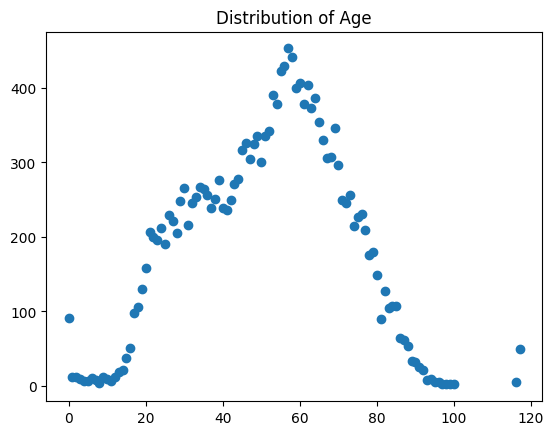

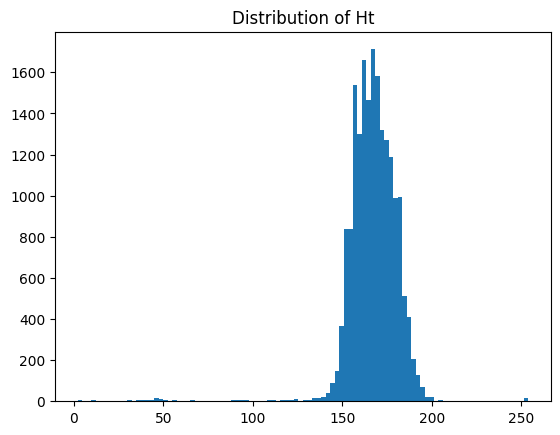

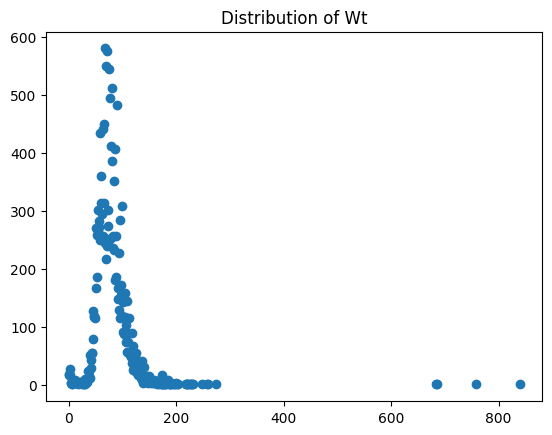

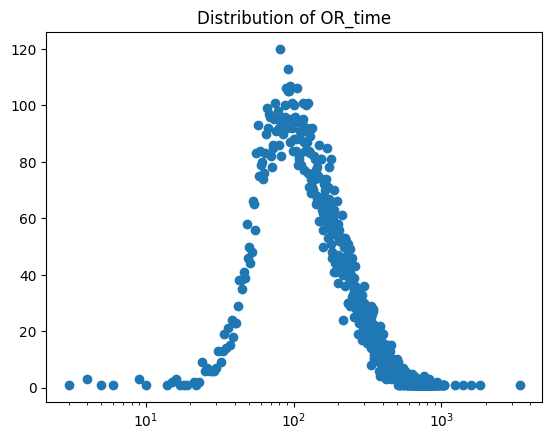

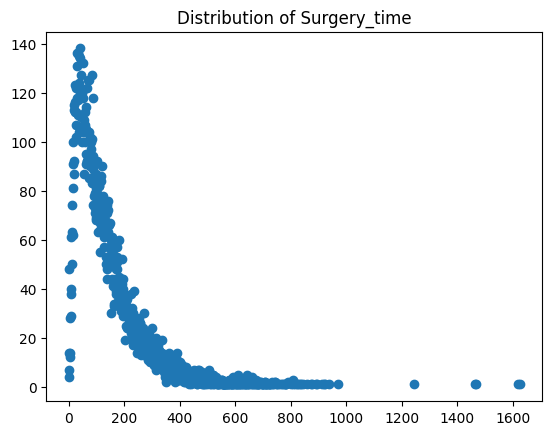

In [7]:
for var in ['Age','Ht','Wt','OR_time','Surgery_time']:
    plt.figure()
    if var == 'Ht':
        plt.hist(info_new[var],bins=100)
    else:
        var_unique, counts = np.unique(info_new[var], return_counts=True)
        plt.scatter(var_unique, counts)
        if var == 'OR_time':
            plt.xscale('log')
    plt.title(f'Distribution of {var}')
    plt.show()

In [8]:
for var in ['Age','Ht','Wt','Sex','OR_time','Surgery_time']:
    print(f'For variable {var}:')
    if var=='Sex':
        print(f'mode={stats.mode(info_new[var]).mode[0]}')
        print(f'class balance: {np.sum(info_new[var])} to {len(info_new)-np.sum(info_new[var])}\n')
    else:
        print(f'mean={np.mean(info_new[var])}')
        print(f'standard deviation={np.std(info_new[var])}\n')

For variable Age:
mean=51.7280771053879
standard deviation=18.694066251880855

For variable Ht:
mean=166.96797809027228
standard deviation=15.297025024405803

For variable Wt:
mean=77.9779849370622
standard deviation=25.720285592142336

For variable Sex:
mode=1
class balance: 9666 to 9321

For variable OR_time:
mean=191.59103597198083
standard deviation=134.64301749487987

For variable Surgery_time:
mean=133.49281087059566
standard deviation=118.00930032555353



<AxesSubplot:>

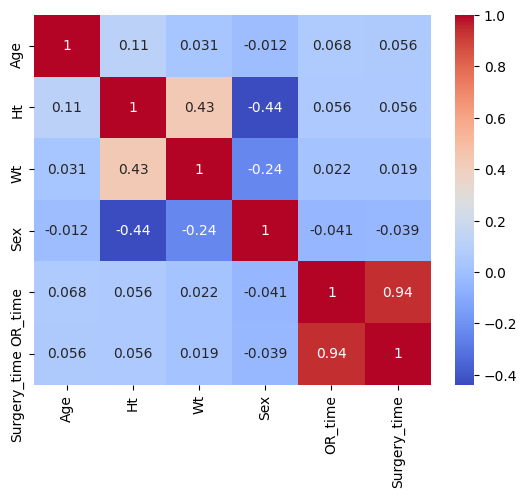

In [9]:
cor_mat = info_new[['Age','Ht','Wt','Sex','OR_time','Surgery_time']].corr()
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

# Outlier Detection

### Mahalanobis (we assume our data to be unimodal because all of our individual distributions were unimodal)

In [10]:
num_data = info_new[['Age','Ht','Wt','Sex','OR_time','Surgery_time']]
mu = list(np.mean(num_data))
iv = np.linalg.inv(num_data.cov())

In [11]:
info_new['Mahalanobis'] = num_data.apply(lambda x: distance.mahalanobis(x,mu,iv),axis=1)

In [12]:
info_new.head()

,PID,Age,Ht,Wt,Sex,OR_time,Surgery_time,Procedure,Mahalanobis
0,56d1bc3e2a07cc1a,19,160,51,1,475.0,405.0,"Funtional rhinoplasty, repair of vestibular st...",3.285183
1,411a637540c1d665,51,162,71,1,81.0,31.0,"Excision Ganglion Cyst left dorsal hand,splint...",1.298779
2,51206705422a4c5c,41,165,58,1,322.0,280.0,"Abdominoplasty, Bilateral Flank Liposuction",1.995911
3,40750c9577f139bd,55,162,66,1,416.0,344.0,"1.Bilateral endoscopic sinus surgery, inferior...",2.093285
4,ed4ac97e460b5a79,41,158,76,1,140.0,84.0,Left breast: Tissue expander Exchange for Sili...,1.213113


In [18]:
# Remove data points with top 5% mahalanobis distance
thresh = np.quantile(list(info_new['Mahalanobis']),0.95)
data = info_new[info_new['Mahalanobis'] < thresh]
print(f'We removed {len(info_new[info_new["Mahalanobis"] >= thresh])} outliers, leaving {len(data)} points remaining')

We removed 950 outliers, leaving 18037 points remaining


<AxesSubplot:>

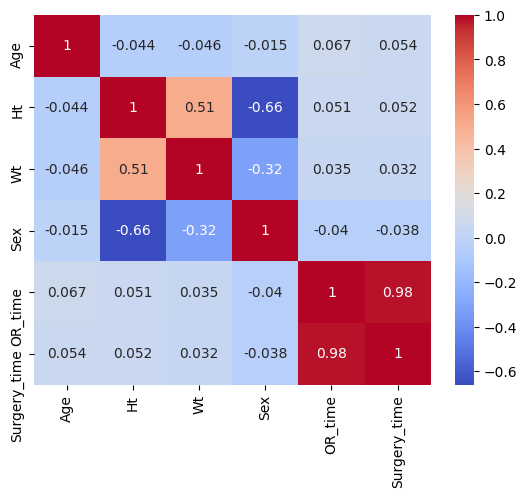

In [19]:
cor_mat_new = data[['Age','Ht','Wt','Sex','OR_time','Surgery_time']].corr()
sns.heatmap(cor_mat_new,cmap='coolwarm',annot=True)